# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
# Load data
pretrial = pd.read_csv("pretrial_data.csv")

In [65]:

# KDE function (no SciPy KDE)
def kde_plot(data, kernel="gaussian", bandwidth=None, grid_points=200, ax=None, label=None):
    # ---- Clean input & basic checks ----
    if isinstance(data, pd.Series):
        data = data.dropna().to_numpy()  # choice: explicit NaN drop for Series
    else:
        data = np.asarray(data)
        data = data[~np.isnan(data)]     # choice: NaN filter for arrays

    n = len(data)
    if n < 2:
        # choice: raise early to avoid divide-by-zero bandwidth issues
        raise ValueError("Need at least 2 observations for KDE.")

    # ---- Silverman's plug-in bandwidth (common default) ----
    # Choice: ddof=1 for sample std (slightly more conservative on small samples)
    std_dev = np.std(data, ddof=1)
    h = (1.06 * std_dev * n ** (-1/5)) if bandwidth is None else float(bandwidth)

    # ---- Vectorized kernel definitions (accept arrays) ----
    def k_gaussian(z):
        return np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

    # "uniform/bump": 1/2 on |z|<=1, 0 otherwise
    def k_uniform(z):
        return 0.5 * (np.abs(z) <= 1)

    # Epanechnikov: 3/4(1 - z^2) on |z|<=1, 0 otherwise
    def k_epanechnikov(z):
        return 0.75 * (1 - z**2) * (np.abs(z) <= 1)

    kernels = {
        "gaussian": k_gaussian,
        "uniform": k_uniform,
        "epanechnikov": k_epanechnikov
    }
    if kernel not in kernels:
        raise ValueError("kernel must be 'gaussian', 'uniform', or 'epanechnikov'")
    kfun = kernels[kernel]

    # ---- Evaluation grid ----
    # Choice: use min..max with a small pad (0.5*std) so edges don't clip
    pad = 0.5 * std_dev if std_dev > 0 else 1.0
    x_min, x_max = data.min() - pad, data.max() + pad
    grid = np.linspace(x_min, x_max, grid_points)

    # ---- Density via broadcasting (fast) ----
    # z has shape (G, n): every grid point vs every sample
    z = (grid[:, None] - data[None, :]) / h
    density = kfun(z).mean(axis=1) / h  # average across samples, then 1/h

    # ---- Plot ----
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(grid, density, label=label or f"{kernel.capitalize()} (h={h:.3g})")
    ax.set_title("Custom Kernel Density Plot")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")

    return grid, density, h


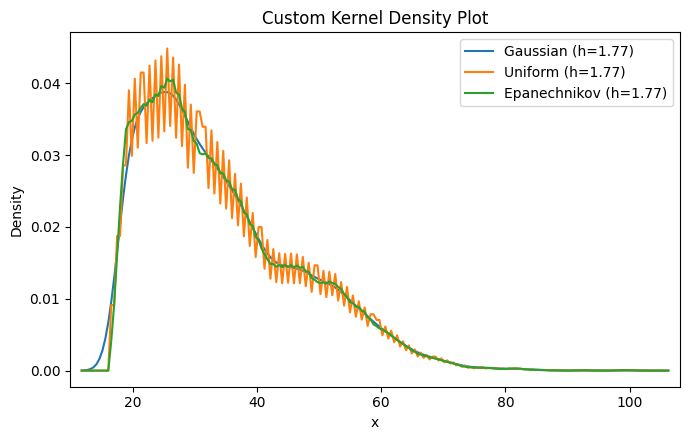

In [66]:
# Demonstration on pretrial['age']
col = "age"  # <-- change this to another numeric column if needed
x = pretrial[col]

fig, ax = plt.subplots(figsize=(7, 4.5))

# Run all three kernels
kde_plot(x, kernel="gaussian", ax=ax) # Pass ax to the function
kde_plot(x, kernel="uniform", ax=ax)   # Pass ax to the function
kde_plot(x, kernel="epanechnikov", ax=ax) # Pass ax to the function

ax.legend()
ax.margins(x=0.02, y=0.05)
plt.tight_layout()
plt.show()

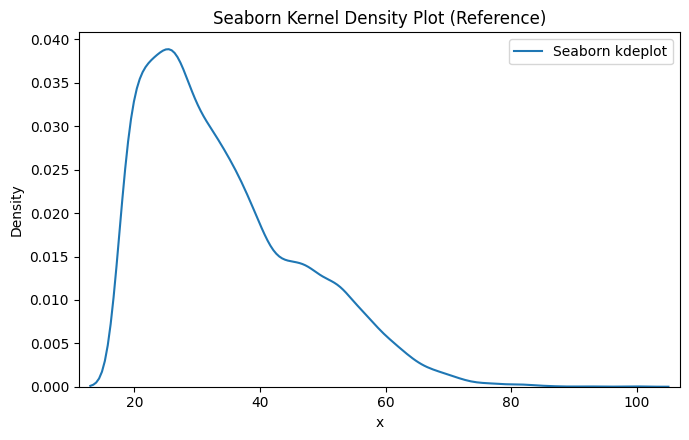

In [67]:
# Comparison with Seaborn's kdeplot
# (for validation only; not used in the function)
plt.figure(figsize=(7, 4.5))
sns.kdeplot(x=x.dropna(), label="Seaborn kdeplot")  # built-in reference
plt.title("Seaborn Kernel Density Plot (Reference)")
plt.xlabel("x")
plt.ylabel("Density")
plt.margins(x=0.02, y=0.05)
plt.legend()
plt.tight_layout()
plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [60]:
# 1. Load the ./data/college_completion.csv data with Pandas.
college_df = pd.read_csv('/content/college_completion.csv')

In [61]:
# 2. What are the dimensions of the data? How many observations are there? What are the variables included? Use .head() to examine the first few rows of data.

# Dimensions of the data (rows, columns)
print("Dimensions of the data:", college_df.shape)

# Number of observations (rows)
print("Number of observations:", college_df.shape[0])

# Variables included (column names)
print("\nVariables included:")
print(college_df.columns.tolist())

# Examine the first few rows
print("\nFirst 5 rows of the data:")
display(college_df.head())

Dimensions of the data: (3798, 63)
Number of observations: 3798

Variables included:
['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_afte

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [69]:
# 3. Cross tabulate `control` and `level`. Describe the patterns you see.
cross_tab = pd.crosstab(college_df['control'], college_df['level'])
print("Cross-tabulation of Control and Level:")
display(cross_tab)

Cross-tabulation of Control and Level:


level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


Part 3: Cross-tabulation of control and level The cross-tabulation shows the distribution of institutions by their control type and level. There are more 4-year institutions overall. Private not-for-profit institutions are heavily concentrated in the 4-year category. Public institutions are more evenly split but have more 2-year colleges. Private for-profit institutions are also relatively balanced between 2-year and 4-year. The least common category is 2-year Private not-for-profit institutions.

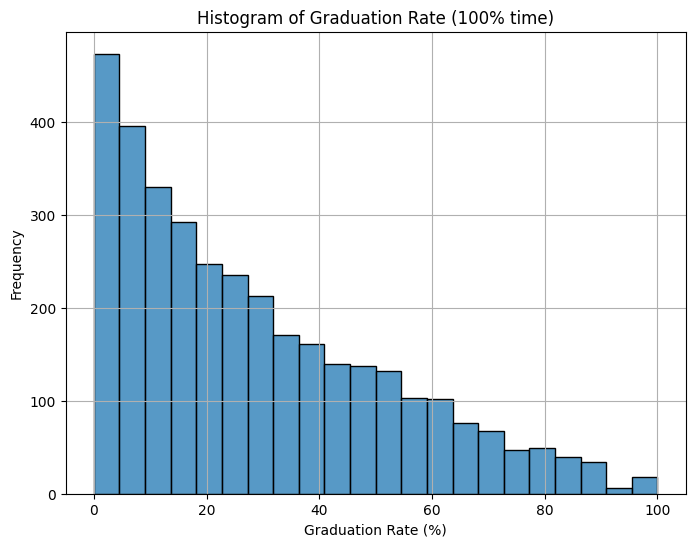

In [71]:
# 4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.

# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=college_df, x='grad_100_value', kde=False)
plt.title("Histogram of Graduation Rate (100% time)")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

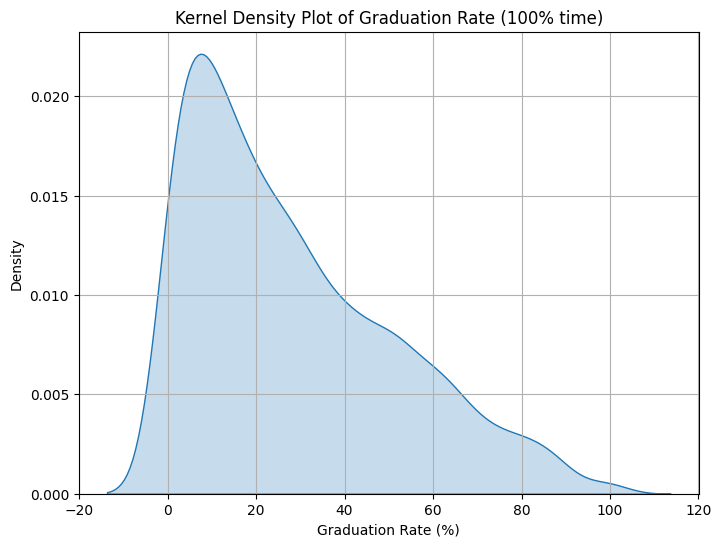

In [72]:
# Kernel Density Plot (using Seaborn for ease)
plt.figure(figsize=(8, 6))
sns.kdeplot(data=college_df, x='grad_100_value', fill=True)
plt.title("Kernel Density Plot of Graduation Rate (100% time)")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

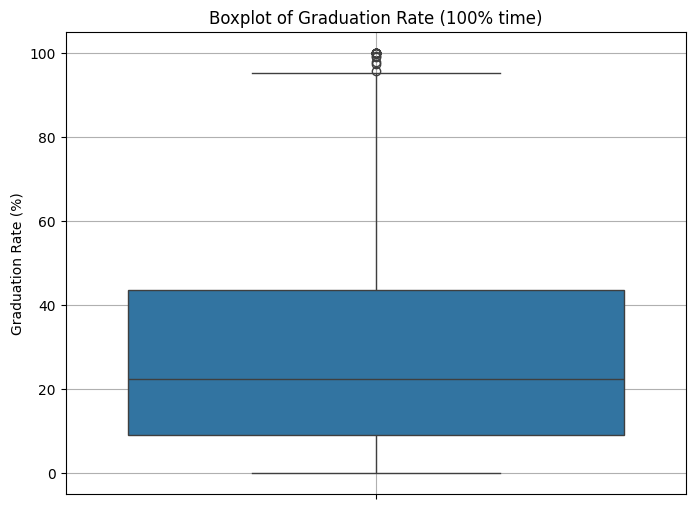

In [73]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=college_df, y='grad_100_value')
plt.title("Boxplot of Graduation Rate (100% time)")
plt.ylabel("Graduation Rate (%)")
plt.grid(True)
plt.show()

In [74]:
# Statistical description
print("\nStatistical description of grad_100_value:")
display(college_df['grad_100_value'].describe())


Statistical description of grad_100_value:


,grad_100_value
count,3467.000000
mean,28.364465
std,23.312730
min,0.000000
25%,9.000000
50%,22.500000
75%,43.650000
max,100.000000


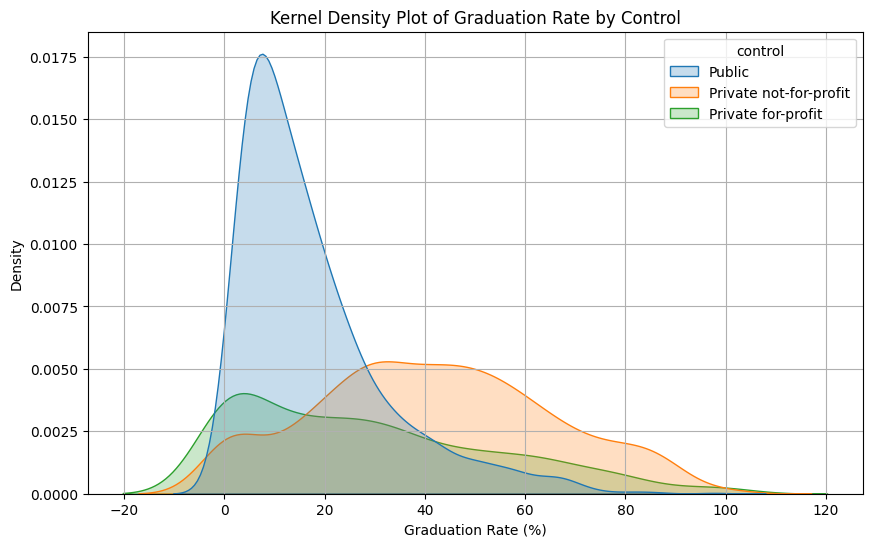

In [75]:
# 5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`.

# Grouped Kernel Density Plot by Control
plt.figure(figsize=(10, 6))
sns.kdeplot(data=college_df, x='grad_100_value', hue='control', fill=True)
plt.title("Kernel Density Plot of Graduation Rate by Control")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

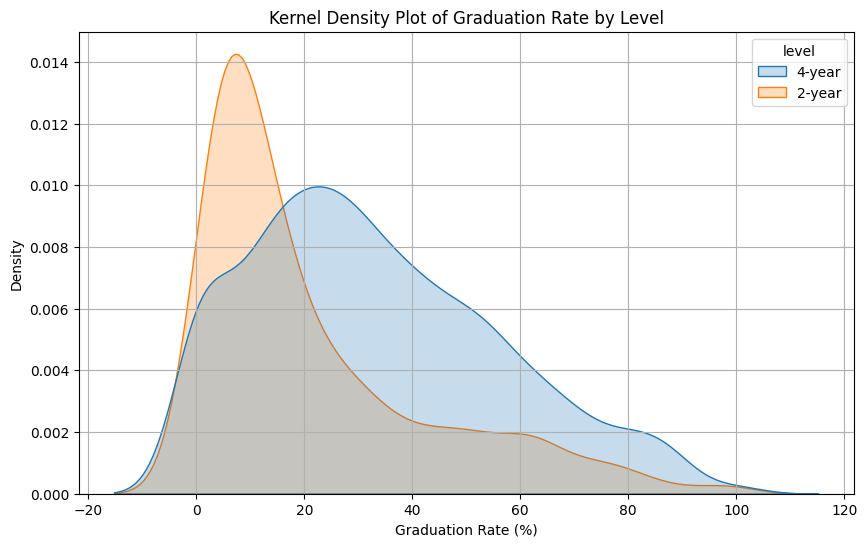

In [76]:
# Grouped Kernel Density Plot by Level
plt.figure(figsize=(10, 6))
sns.kdeplot(data=college_df, x='grad_100_value', hue='level', fill=True)
plt.title("Kernel Density Plot of Graduation Rate by Level")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [77]:
# Use groupby and .describe to make grouped calculations of statistical descriptions of grad_100_value by level and control.

print("\nStatistical description of grad_100_value by Level:")
display(college_df.groupby('level')['grad_100_value'].describe())

print("\nStatistical description of grad_100_value by Control:")
display(college_df.groupby('control')['grad_100_value'].describe())


Statistical description of grad_100_value by Level:


,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
2-year,1455.0,21.636151,21.645747,0.0,6.0,13.0,30.600,100.0
4-year,2012.0,33.230119,23.270160,0.0,15.2,29.7,49.225,100.0



Statistical description of grad_100_value by Control:


,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,779.0,29.108858,25.601687,0.0,6.95,24.7,46.75,100.0
Private not-for-profit,1189.0,41.660976,23.551231,0.0,25.00,41.0,58.30,100.0
Public,1499.0,17.430887,14.729443,0.0,6.90,13.2,23.25,97.8


Part 4: grad_100_value description The statistical description of grad_100_value shows that the average 100% graduation rate is approximately 28.36%, with a standard deviation of about 23.31%. The rates range from 0% to 100%. The median is 22.5%, indicating the distribution is skewed, with a long tail towards higher graduation rates. The histogram and kernel density plot visually confirm this right skew. The boxplot highlights the median, quartiles, and the presence of outliers at higher graduation rates.

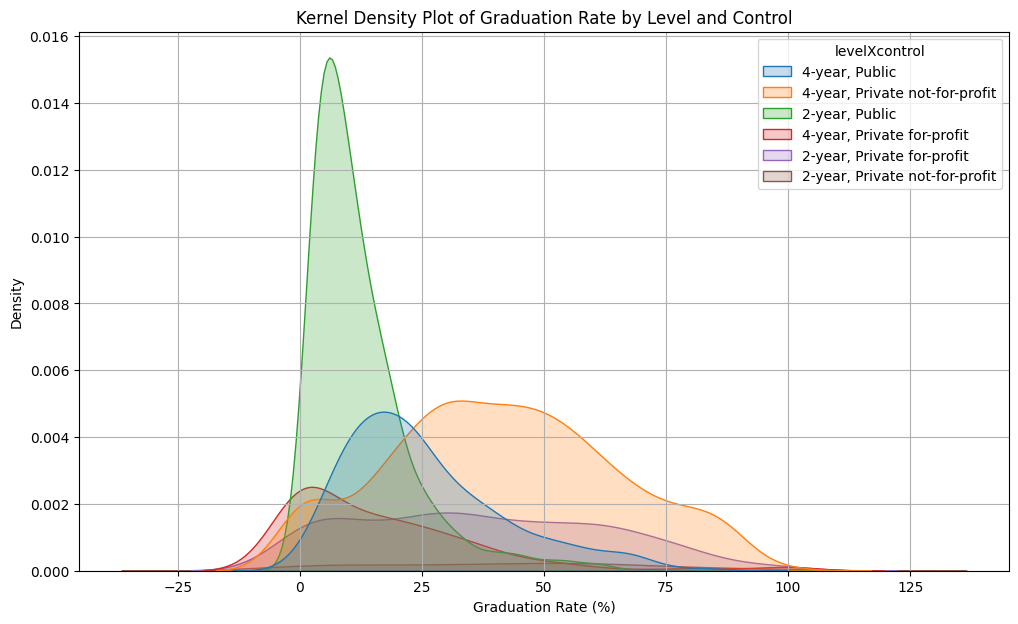

In [78]:
# 6. Create a new variable, df['levelXcontrol']=df['level']+', '+df['control'] that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?

# Create the interaction variable
college_df['levelXcontrol'] = college_df['level'] + ', ' + college_df['control']

# Make a grouped kernel density plot
plt.figure(figsize=(12, 7))
sns.kdeplot(data=college_df, x='grad_100_value', hue='levelXcontrol', fill=True)
plt.title("Kernel Density Plot of Graduation Rate by Level and Control")
plt.xlabel("Graduation Rate (%)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Part 6: levelXcontrol grouped plot and best rates The grouped kernel density plot using the levelXcontrol interaction variable further clarifies the distributions. It distinctly shows that 4-year, Private not-for-profit institutions have the highest density at higher graduation rates compared to all other combinations of level and control. This reinforces the conclusion from Part 5 that these institutions appear to have the best 100% graduation rates.

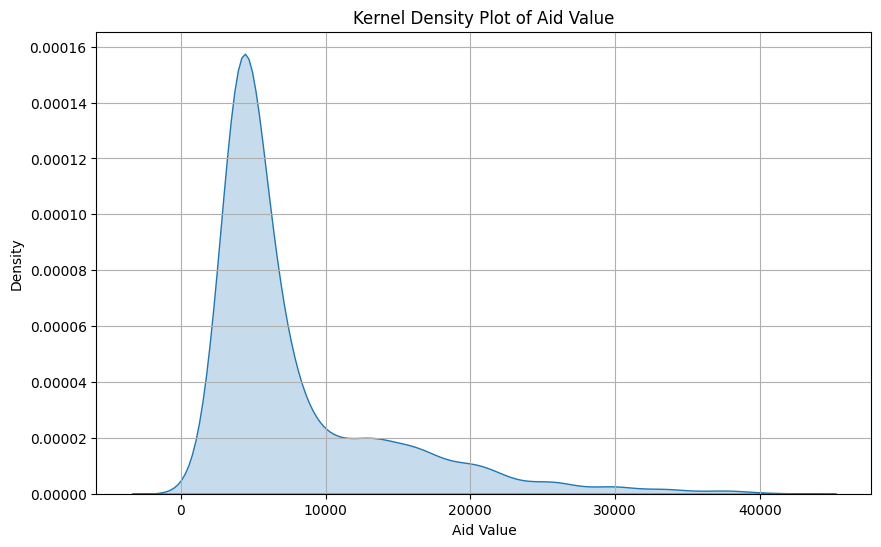

In [79]:
# 7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`.

# Kernel density plot of aid_value
plt.figure(figsize=(10, 6))
sns.kdeplot(data=college_df, x='aid_value', fill=True)
plt.title("Kernel Density Plot of Aid Value")
plt.xlabel("Aid Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

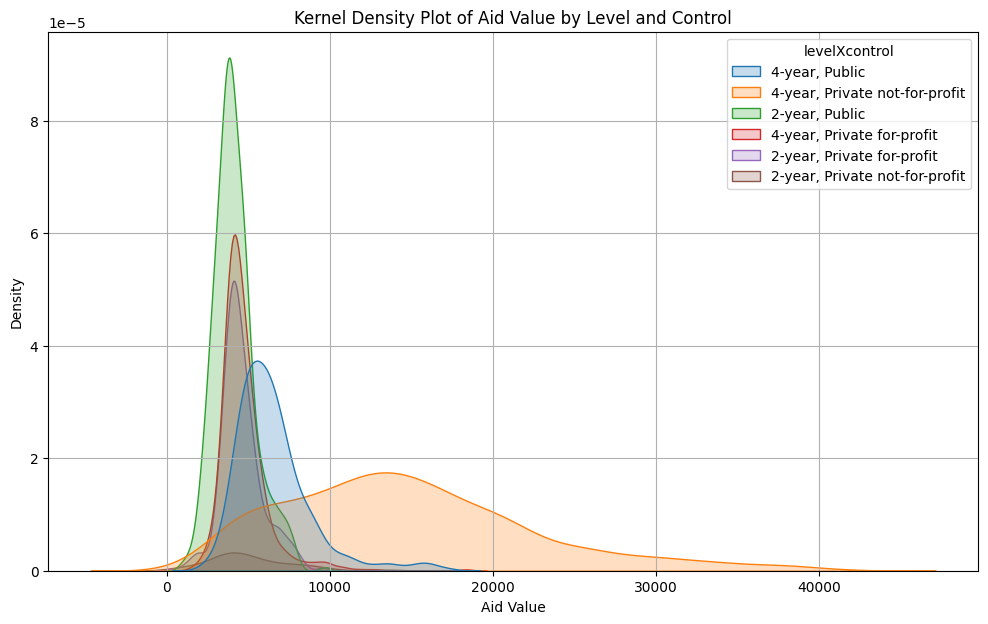

In [80]:
# Grouped kernel density plot of aid_value by level and control
plt.figure(figsize=(12, 7))
sns.kdeplot(data=college_df, x='aid_value', hue='levelXcontrol', fill=True)
plt.title("Kernel Density Plot of Aid Value by Level and Control")
plt.xlabel("Aid Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [81]:
# Use groupby and .describe to make grouped calculations of statistical descriptions of aid_value by level and control.

print("\nStatistical description of aid_value by Level:")
display(college_df.groupby('level')['aid_value'].describe())

print("\nStatistical description of aid_value by Control:")
display(college_df.groupby('control')['aid_value'].describe())

print("\nStatistical description of aid_value by Level and Control:")
display(college_df.groupby(['level', 'control'])['aid_value'].describe())


Statistical description of aid_value by Level:


,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
2-year,1458.0,4310.878601,1384.045631,294.0,3485.5,4113.0,4890.0,13654.0
4-year,2339.0,10235.379222,7227.369167,902.0,4830.5,7222.0,14046.0,41580.0



Statistical description of aid_value by Control:


,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,991.0,4632.206862,1399.121259,294.0,3861.50,4331.0,5131.5,18355.0
Private not-for-profit,1248.0,14180.722756,7772.700998,902.0,8325.00,13322.0,18571.0,41580.0
Public,1558.0,5094.835687,2136.436370,881.0,3725.25,4667.0,6087.5,17299.0



Statistical description of aid_value by Level and Control:


count          mean          std     min  \
level  control                                                             
2-year Private for-profit       464.0   4559.681034  1286.688269   294.0   
       Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
       Public                   926.0   4126.199784  1260.271382   881.0   
4-year Private for-profit       527.0   4696.062619  1489.410020  1580.0   
       Private not-for-profit  1180.0  14702.401695  7649.775203   902.0   
       Public                   632.0   6514.071203  2353.716693  2232.0   

                                   25%      50%       75%      max  
level  control                                                      
2-year Private for-profit      3818.75   4286.5   5122.00   9727.0  
       Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
       Public                  3311.25   3943.5   4762.00   9809.0  
4-year Private for-profit      3885.50   4364.0   5131.50  18355.0  
       Private not-for-profit  9113.25  13774.5  18996.75  41580.0  
       Public                  4990.50   6085.0   7341.50  17299.0

Part 7: aid_value plots and description The overall kernel density plot for aid_value shows a distribution with a large peak at lower aid values and a smaller bump at higher values. The grouped kernel density plot by level and control explains this shape: 2-year institutions and 4-year Public institutions are concentrated at lower aid values, while 4-year Private not-for-profit institutions have a distribution centered at much higher aid values. The grouped statistical descriptions confirm that 4-year Private not-for-profit institutions have the highest average aid values.


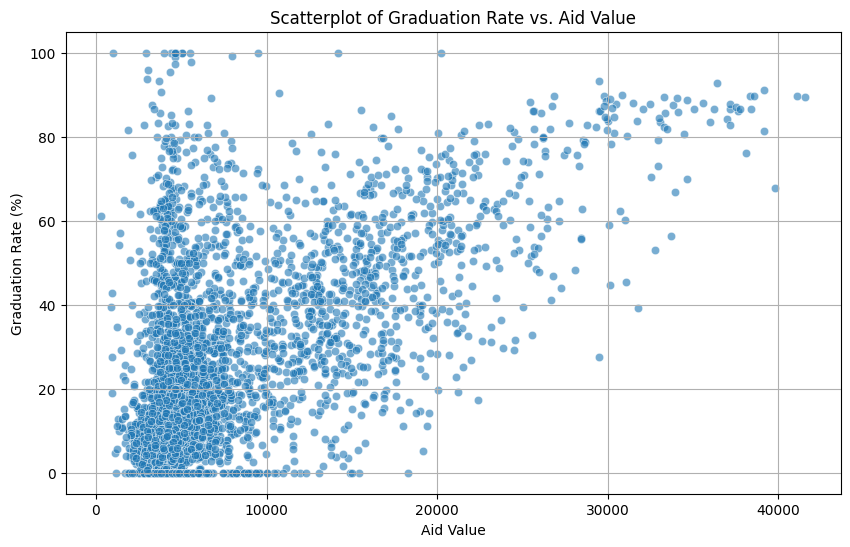

In [82]:
# 8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

# Overall Scatterplot of grad_100_value by aid_value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value', alpha=0.6)
plt.title("Scatterplot of Graduation Rate vs. Aid Value")
plt.xlabel("Aid Value")
plt.ylabel("Graduation Rate (%)")
plt.grid(True)
plt.show()

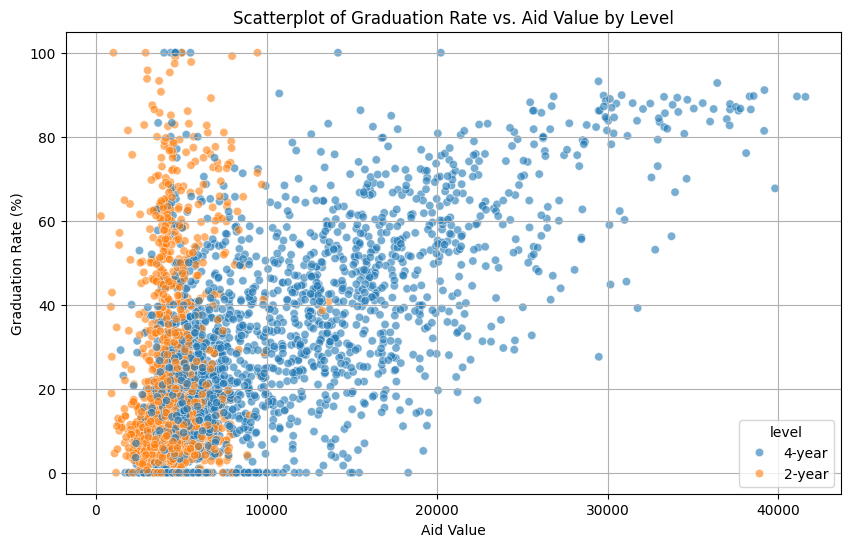

In [83]:
# Scatterplot of grad_100_value by aid_value, grouped by level
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value', hue='level', alpha=0.6)
plt.title("Scatterplot of Graduation Rate vs. Aid Value by Level")
plt.xlabel("Aid Value")
plt.ylabel("Graduation Rate (%)")
plt.grid(True)
plt.show()

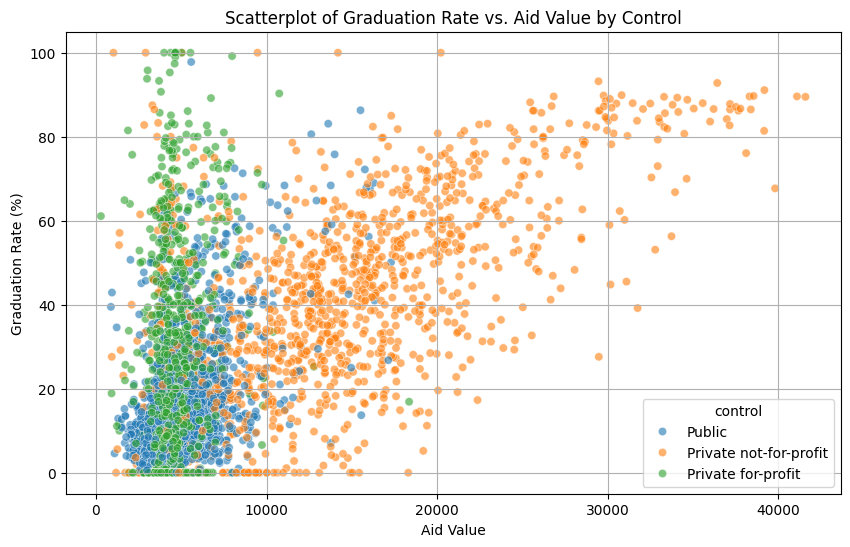

In [84]:
# Scatterplot of grad_100_value by aid_value, grouped by control
plt.figure(figsize=(10, 6))
sns.scatterplot(data=college_df, x='aid_value', y='grad_100_value', hue='control', alpha=0.6)
plt.title("Scatterplot of Graduation Rate vs. Aid Value by Control")
plt.xlabel("Aid Value")
plt.ylabel("Graduation Rate (%)")
plt.grid(True)
plt.show()

Part 8: grad_100_value by aid_value scatterplots and aid impact The overall scatterplot shows a general positive association between aid_value and grad_100_value. When grouped by level, 4-year institutions show a clearer positive trend than 2-year institutions, which are clustered at lower values. Grouped by control, Private not-for-profit institutions show the strongest visual evidence of a positive relationship between aid value and graduation rate, with a notable cluster of institutions that have both high aid and high graduation rates. For Public and Private for-profit institutions, the relationship appears weaker or less consistent. Therefore, aid seems most strongly associated with increased graduation rates for Private not-for-profit 4-year institutions.